In [2]:
import os
import json
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from pyproj import Transformer
from tqdm import tqdm
import pickle

In [53]:
# 获取当前日期
def get_dtime():
    # 例如20240516
    import datetime
    dtime = datetime.datetime.now().strftime('%Y%m%d')
    return dtime

In [54]:
# 导入autogluon模型
model_path = r"F:\cache_data\zone_ana\ky\modle\autogluon_type"

In [55]:
# 砂岩
sy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'sdt'))
sy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'fzrt'))
sy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'zrt'))
# 碳酸岩
tsy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'sdt'))
tsy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'fzrt'))
tsy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'zrt'))
# 第四纪红色粘土
hnt_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'sdt'))
hnt_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'fzrt'))
hnt_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'zrt'))
# 泥页岩
nyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'sdt'))
nyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'fzrt'))
nyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'zrt'))
# 紫红色砂页岩
zhsyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'sdt'))
zhsyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'fzrt'))
zhsyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'zrt'))
# 河流冲积物
hlcjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'sdt'))
hlcjw_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'fzrt'))
hlcjw_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'zrt'))
# 砂页岩
syy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'sdt'))
syy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'fzrt'))
syy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'zrt'))
# 玄武岩
xwy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'xwy'),'sdt'))
xwy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'xwy'),'fzrt'))
xwy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'xwy'),'zrt'))


In [56]:
# 获取特征函数

def get_feature_names(predictor):
    feature_names = predictor.feature_metadata_in.get_features()
    return feature_names
sdt_feature_names = syy_sdt_predictor.feature_metadata_in.get_features()
print("SDT",sdt_feature_names)
fzrt_feature_names = syy_fzrt_predictor.feature_metadata_in.get_features()
print("FZRT",fzrt_feature_names)
zrt_feature_names = syy_zrt_predictor.feature_metadata_in.get_features()
print("ZRT",zrt_feature_names)

SDT ['analyticalhillshading', 'aspect', 'channelnetworkbaselevel', 'channelnetworkdistance', 'convergenceindex', 'dem', 'dz', 'dl', 'etp2022_1', 'etp2022_10', 'etp2022_11', 'etp2022_12', 'etp2022_2', 'etp2022_3', 'etp2022_4', 'etp2022_5', 'etp2022_6', 'etp2022_7', 'etp2022_8', 'etp2022_9', 'etp2022_mean', 'evi', 'lat', 'lon', 'lswi', 'lsfactor', 'mndwi', 'mrttf', 'mrvbf', 'ndvi', 'ndwi', 'night2022', 'pc1', 'pc2', 'plancurvature', 'pre2022_1', 'pre2022_10', 'pre2022_11', 'pre2022_12', 'pre2022_2', 'pre2022_3', 'pre2022_4', 'pre2022_5', 'pre2022_6', 'pre2022_7', 'pre2022_8', 'pre2022_9', 'pre2022_mean', 'profilecurvature', 'relativeslopeposition', 'savi', 'slope', 'slope_postion', 'tmp2022_1', 'tmp2022_10', 'tmp2022_11', 'tmp2022_12', 'tmp2022_2', 'tmp2022_3', 'tmp2022_4', 'tmp2022_5', 'tmp2022_6', 'tmp2022_7', 'tmp2022_8', 'tmp2022_9', 'tmp2022_mean', 'topographicwetnessindex', 'totalcatchmentarea', 'valleydepth', 'vari']
FZRT ['analyticalhillshading', 'aspect', 'channelnetworkbaseleve

In [57]:
# 存放预测结果的路径
result_path =  r"F:\cache_data\zone_ana\ky\prediction_result"
if not os.path.exists(result_path):
    os.makedirs(result_path)


In [58]:
# 读取数据集
feature_path = r"F:\cache_data\zone_ana\ky\train_data\soil_type_predict.csv"

In [59]:
feature_df = pd.read_csv(feature_path)

C:\Users\Runker\AppData\Local\Temp\ipykernel_20848\3221913873.py:1: DtypeWarning: Columns (5,19,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_df = pd.read_csv(feature_path)


In [60]:
feature_df.shape[0]

522442

In [61]:
[_ for _ in feature_df.columns]

['FID',
 'FID_ky_sd_',
 'OBJECTID',
 'BSM',
 'YSDM',
 'TBYBH',
 'TBBH',
 'DLBM',
 'DLMC',
 'QSXZ',
 'QSDWDM',
 'QSDWMC',
 'ZLDWDM',
 'ZLDWMC',
 'TBMJ',
 'KCDLBM',
 'KCXS',
 'KCMJ',
 'TBDLMJ',
 'GDLX',
 'GDPDJB',
 'XZDWKD',
 'TBXHDM',
 'TBXHMC',
 'ZZSXDM',
 'ZZSXMC',
 'GDDB',
 'FRDBS',
 'CZCSXM',
 'SJNF',
 'MSSM',
 'HDMC',
 'BZ',
 '原始',
 '更新乡',
 '更新村',
 'Shape_Leng',
 'Shape_Area',
 'DLDM',
 'DLLB',
 'FID_ky_dz_',
 'MZMC',
 'FID_ky_slo',
 'Id',
 'gridcode',
 'InPoly_FID',
 'SmoPgnFlag',
 'ORIG_FID',
 'area',
 'min_width',
 'threshold',
 'geometry',
 'analyticalhillshading_min',
 'analyticalhillshading_max',
 'analyticalhillshading_mean',
 'analyticalhillshading_count',
 'analyticalhillshading_std',
 'analyticalhillshading_majority',
 'aspect_min',
 'aspect_max',
 'aspect_mean',
 'aspect_count',
 'aspect_std',
 'aspect_majority',
 'bio_min',
 'bio_max',
 'bio_mean',
 'bio_count',
 'bio_std',
 'bio_majority',
 'channelnetworkbaselevel_min',
 'channelnetworkbaselevel_max',
 'channelnetwork

In [64]:
# 重命名列
# 保留名称中包含'MEAN'、'MAJORITY'和'PCT90'的列,删除其他列
keep_cols = ['FID', 'DLBM', 'DLMC', 'DLLB','MZMC','gridcode']  # 保留的基础列
keep_cols.extend([col for col in feature_df.columns if 'mean' in col or 'majority' in col or 'PCT90' in col])  # 添加需要保留的特征列

# 只保留指定的列
feature_df = feature_df[keep_cols]

In [65]:
feature_df.head()[['FID','dem_mean','dl_majority','dz_majority']]


,FID,dem_mean,dl_majority,dz_majority
0,0,1230.971394,1.0,2.0
1,1,1223.616943,1.0,3.0
2,2,1250.249026,3.0,3.0
3,3,1196.002159,3.0,3.0
4,4,1227.487659,9.0,3.0


In [66]:
# 创建一个字典来存储新的列名映射
rename_dict = {}

# 遍历所有列名
for col in feature_df.columns:
    if col.endswith('_mean') and col not in ['dl_mean', 'dz_mean']:
        # 获取基础名称（去掉后缀）
        base_name = col[:-5]  # 去掉'_mean'
        rename_dict[col] = base_name
            
# 直接添加我们想要的两个映射
rename_dict['dl_majority'] = 'dl'
rename_dict['dz_majority'] = 'dz'

In [67]:
rename_dict

{'analyticalhillshading_mean': 'analyticalhillshading',
 'aspect_mean': 'aspect',
 'bio_mean': 'bio',
 'channelnetworkbaselevel_mean': 'channelnetworkbaselevel',
 'channelnetworkdistance_mean': 'channelnetworkdistance',
 'closeddepressions_mean': 'closeddepressions',
 'contrast_mean': 'contrast',
 'convergenceindex_mean': 'convergenceindex',
 'correlation_mean': 'correlation',
 'dem_mean': 'dem',
 'dissimilarity_mean': 'dissimilarity',
 'entropy_mean': 'entropy',
 'etp2022_1_mean': 'etp2022_1',
 'etp2022_10_mean': 'etp2022_10',
 'etp2022_11_mean': 'etp2022_11',
 'etp2022_12_mean': 'etp2022_12',
 'etp2022_2_mean': 'etp2022_2',
 'etp2022_3_mean': 'etp2022_3',
 'etp2022_4_mean': 'etp2022_4',
 'etp2022_5_mean': 'etp2022_5',
 'etp2022_6_mean': 'etp2022_6',
 'etp2022_7_mean': 'etp2022_7',
 'etp2022_8_mean': 'etp2022_8',
 'etp2022_9_mean': 'etp2022_9',
 'etp2022_mean_mean': 'etp2022_mean',
 'evi_mean': 'evi',
 'homogeneity_mean': 'homogeneity',
 'lat_mean': 'lat',
 'lon_mean': 'lon',
 'lsfact

In [68]:
# 重命名列
feature_df = feature_df.rename(columns=rename_dict)

In [69]:
[_ for _ in feature_df.columns]

['FID',
 'DLBM',
 'DLMC',
 'DLLB',
 'MZMC',
 'gridcode',
 'analyticalhillshading',
 'analyticalhillshading_majority',
 'aspect',
 'aspect_majority',
 'bio',
 'bio_majority',
 'channelnetworkbaselevel',
 'channelnetworkbaselevel_majority',
 'channelnetworkdistance',
 'channelnetworkdistance_majority',
 'closeddepressions',
 'closeddepressions_majority',
 'contrast',
 'contrast_majority',
 'convergenceindex',
 'convergenceindex_majority',
 'correlation',
 'correlation_majority',
 'dem',
 'dem_majority',
 'dissimilarity',
 'dissimilarity_majority',
 'dl_mean',
 'dl',
 'dz_mean',
 'dz',
 'entropy',
 'entropy_majority',
 'etp2022_1',
 'etp2022_1_majority',
 'etp2022_10',
 'etp2022_10_majority',
 'etp2022_11',
 'etp2022_11_majority',
 'etp2022_12',
 'etp2022_12_majority',
 'etp2022_2',
 'etp2022_2_majority',
 'etp2022_3',
 'etp2022_3_majority',
 'etp2022_4',
 'etp2022_4_majority',
 'etp2022_5',
 'etp2022_5_majority',
 'etp2022_6',
 'etp2022_6_majority',
 'etp2022_7',
 'etp2022_7_majority',
 

In [70]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,FID,DLBM,DLMC,DLLB,MZMC,gridcode,analyticalhillshading,analyticalhillshading_majority,aspect,aspect_majority,...,valleydepth,valleydepth_majority,vap,vap_majority,vari,vari_majority,variance,variance_majority,wind,wind_majority


In [71]:
# 选择数值类型的列
numeric_cols = feature_df.select_dtypes(include=[np.float64])

# 计算数值列的均值
mean_values = numeric_cols.mean()

# 用均值填充数值列的空值
feature_df[numeric_cols.columns] = numeric_cols.fillna(mean_values)

In [72]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,FID,DLBM,DLMC,DLLB,MZMC,gridcode,analyticalhillshading,analyticalhillshading_majority,aspect,aspect_majority,...,valleydepth,valleydepth_majority,vap,vap_majority,vari,vari_majority,variance,variance_majority,wind,wind_majority


In [73]:
dataset = feature_df

In [74]:
dataset.columns

Index(['FID', 'DLBM', 'DLMC', 'DLLB', 'MZMC', 'gridcode',
       'analyticalhillshading', 'analyticalhillshading_majority', 'aspect',
       'aspect_majority',
       ...
       'valleydepth', 'valleydepth_majority', 'vap', 'vap_majority', 'vari',
       'vari_majority', 'variance', 'variance_majority', 'wind',
       'wind_majority'],
      dtype='object', length=192)

In [75]:

duplicated_rows = dataset[dataset['FID'].duplicated(keep=False)]

In [76]:
duplicated_rows

,FID,DLBM,DLMC,DLLB,MZMC,gridcode,analyticalhillshading,analyticalhillshading_majority,aspect,aspect_majority,...,valleydepth,valleydepth_majority,vap,vap_majority,vari,vari_majority,variance,variance_majority,wind,wind_majority


In [77]:
# 统计总数据中各个岩石类型的总数
value_counts_dict = dataset['MZMC'].value_counts().to_dict()
value_counts_dict

{'白云岩': 195849,
 '灰岩': 119443,
 '页岩': 55016,
 '泥(页)岩': 51663,
 '粘土岩': 40451,
 '砂页岩': 25595,
 '砂岩': 11710,
 '变余凝灰岩': 9860,
 '变余砂岩': 3218,
 '紫色砂岩': 3002,
 '河流冲积物': 2751,
 '玄武岩': 2415,
 '板岩': 896,
 '砾岩': 345,
 '第四纪粘土': 228}

In [78]:
# 筛选砂岩水稻土数据
sy_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      & ((dataset['MZMC'] == '砂岩')|
                         (dataset['MZMC'] == '变余砂岩'))]
# 筛砂岩选非自然土数据
sy_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                       & ((dataset['MZMC'] == '砂岩')|
                          (dataset['MZMC'] == '变余砂岩'))]
# 筛选自然土数据
sy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '砂岩') |
                      (dataset['MZMC'] == '变余砂岩'))]
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0],value_counts_dict['砂岩']+value_counts_dict['变余砂岩'])

14928 14928


In [79]:
# 筛选碳酸岩水稻土数据
tsy_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩') | (dataset['MZMC'] == '变余凝灰岩'))]

# 筛选碳酸岩选非自然土数据
tsy_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                        & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩') | (dataset['MZMC'] == '变余凝灰岩'))]

# 筛选碳酸岩自然土数据
tsy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩') | (dataset['MZMC'] == '变余凝灰岩'))]
print(tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0],value_counts_dict['白云岩']+value_counts_dict['灰岩']+value_counts_dict['变余凝灰岩'])

325152 325152


In [80]:
# 筛选第四系红粘土水稻土数据
hnt_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      & ((dataset['MZMC'] == '第四纪粘土'))]

# 筛选第四系红粘土非自然土数据
hnt_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                       & ((dataset['MZMC'] == '第四纪粘土'))]

# 筛选第四系红粘土自然土数据
hnt_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '第四纪粘土'))]
print(hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0],value_counts_dict['第四纪粘土'])

228 228


In [81]:
# 筛选泥(页)岩水稻土数据
nyy_sdt_data = dataset[(dataset['DLLB']=='水稻土')
                   & ((dataset['MZMC'] == '泥(页)岩') | (dataset['MZMC'] == '页岩')|
                      (dataset['MZMC'] == '粘土岩')|
                      (dataset['MZMC'] == '板岩'))]

# 筛选泥(页)岩非自然土数据
nyy_fzrt_data = dataset[(dataset['DLLB']=='非自然土')
                       & ((dataset['MZMC'] == '泥(页)岩') | (dataset['MZMC'] == '页岩')|
                      (dataset['MZMC'] == '粘土岩')|
                      (dataset['MZMC'] == '板岩'))]

# 筛选泥(页)岩自然土数据
nyy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '泥(页)岩') | (dataset['MZMC'] == '页岩')|
                      (dataset['MZMC'] == '粘土岩')|
                      (dataset['MZMC'] == '板岩'))]
print(nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0],value_counts_dict['泥(页)岩']+value_counts_dict['页岩']+value_counts_dict['粘土岩']+value_counts_dict['板岩'])

148026 148026


In [82]:
# 筛选紫红色砂页岩水稻土数据
zhsyy_sdt_data = dataset[(dataset['DLLB']=='水稻土')
                      &((dataset['MZMC'] == '紫色砂岩'))]

# 筛选紫红色砂页岩非自然土数据
zhsyy_fzrt_data = dataset[(dataset['DLLB']=='非自然土')
                       & ((dataset['MZMC'] == '紫色砂岩'))]

# 筛选紫红色砂页岩自然土数据
zhsyy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '紫色砂岩'))]
print(zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0],value_counts_dict['紫色砂岩'])

3002 3002


In [83]:
# 筛选河流冲积物水稻土数据
hlcjw_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      &(dataset['MZMC'] == '河流冲积物')]
# 筛选河流冲积物非自然土数据
hlcjw_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                       & (dataset['MZMC'] == '河流冲积物')]
# 筛选河流冲积物自然土数据
hlcjw_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & (dataset['MZMC'] == '河流冲积物')]
print(hlcjw_sdt_data.shape[0]+hlcjw_fzrt_data.shape[0]+hlcjw_zrt_data.shape[0],value_counts_dict['河流冲积物'])

2751 2751


In [84]:
# 筛选砂页岩水稻土数据
syy_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      & ((dataset['MZMC'] == '砂页岩')|
                         (dataset['MZMC'] == '砾岩'))]

# 筛选砂页岩非自然土数据
syy_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                       & ((dataset['MZMC'] == '砂页岩')|(dataset['MZMC'] == '砾岩'))]

# 筛选砂页岩自然土数据
syy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '砂页岩')|
                      (dataset['MZMC'] == '砾岩'))]
print(syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0],value_counts_dict['砂页岩']+value_counts_dict['砾岩'])


25940 25940


In [85]:
# 筛选玄武岩水稻土数据
xwy_sdt_data = dataset[(dataset['DLLB']=='水稻土') 
                      & ((dataset['MZMC'] == '玄武岩'))]
# 筛选玄武岩非自然土数据 
xwy_fzrt_data = dataset[(dataset['DLLB']=='非自然土') 
                       & ((dataset['MZMC'] == '玄武岩'))]

# 筛选玄武岩自然土数据
xwy_zrt_data = dataset[(dataset['DLLB']=='自然土')
                   & ((dataset['MZMC'] == '玄武岩'))]
print(xwy_sdt_data.shape[0]+xwy_fzrt_data.shape[0]+xwy_zrt_data.shape[0],value_counts_dict['玄武岩'])


2415 2415


In [86]:
# 查看各个数据集的大小
print('砂岩',sy_sdt_data.shape,sy_fzrt_data.shape,sy_zrt_data.shape)
print('碳酸盐岩',tsy_sdt_data.shape,tsy_fzrt_data.shape,tsy_zrt_data.shape)
print('第四纪红色粘土',hnt_sdt_data.shape,hnt_fzrt_data.shape,hnt_zrt_data.shape)
print('泥页岩',nyy_sdt_data.shape,nyy_fzrt_data.shape,nyy_zrt_data.shape)
print('紫红色砂(页)岩',zhsyy_sdt_data.shape,zhsyy_fzrt_data.shape,zhsyy_zrt_data.shape)
print('河流冲积物',hlcjw_sdt_data.shape,hlcjw_fzrt_data.shape,hlcjw_zrt_data.shape)
print('砂(页)岩',syy_sdt_data.shape,syy_fzrt_data.shape,syy_zrt_data.shape)
print('玄武岩',xwy_sdt_data.shape,xwy_fzrt_data.shape,xwy_zrt_data.shape)
# 计算总和
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0]+tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0]+hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0]+nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0]+zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0]+hlcjw_sdt_data.shape[0]+hlcjw_fzrt_data.shape[0]+ hlcjw_zrt_data.shape[0]+syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0]+xwy_sdt_data.shape[0]+xwy_fzrt_data.shape[0]+xwy_zrt_data.shape[0])
# 数据总和
print(feature_df.shape[0])


砂岩 (1551, 192) (5148, 192) (8229, 192)
碳酸盐岩 (27877, 192) (118862, 192) (178413, 192)
第四纪红色粘土 (14, 192) (78, 192) (136, 192)
泥页岩 (13358, 192) (53888, 192) (80780, 192)
紫红色砂(页)岩 (96, 192) (815, 192) (2091, 192)
河流冲积物 (1486, 192) (754, 192) (511, 192)
砂(页)岩 (3489, 192) (8215, 192) (14236, 192)
玄武岩 (328, 192) (1001, 192) (1086, 192)
522442
522442


In [87]:
# 获取对照字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict_20241216_ky.json', 'r') as f:
    soil_dict = json.load(f)
# 将键转为int
soil_dict = {int(k):v for k, v in soil_dict.items()}

In [88]:
zhsyy_sdt_predictor.model_names()

['RandomForestGini',
 'RandomForestEntr',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'NeuralNetFastAI',
 'WeightedEnsemble_L2']

In [118]:
# 模型选择
# select_model = 'WeightedEnsemble_L2'
select_model = 'RandomForestGini'
# select_model = 'RandomForestEntr'

In [108]:
# 概率预测函数
def predict_top_classes(data, predictor,feature_names, model, top_n, soil_dict):
    """
    根据给定的AutoGluon模型，预测数据集中的前n个最可能的类别及其概率，并根据提供的字典转换类别编号为描述字符串。
    参数:
    data (DataFrame): 输入的数据集。
    predictor（model）: 对应的模型
    feature_names (list): 用于预测的特征名列表。
    model (str): 选择的模型名称。
    top_n (int): 需要返回的最高概率的类别数量。
    soil_dict (dict): 类别编号到描述字符串的映射字典。
    
    返回:
    DataFrame: 原始数据与预测结果合并后的DataFrame。
    """
    # 复制数据
    data = data.copy()
    # 预测概率
    pred_probs = predictor.predict_proba(data[feature_names], model=model)
    # 获取概率最高的前n个类别及其概率
    top_classes = pred_probs.apply(lambda x: pd.Series(x.nlargest(top_n).index.astype(int).tolist() + x.nlargest(top_n).values.tolist()), axis=1)
    # 重命名列
    class_cols = ['Class{}'.format(i+1) for i in range(top_n)]
    prob_cols = ['Prob{}'.format(i+1) for i in range(top_n)]
    top_classes.columns = class_cols + prob_cols
    # 转换类别编号为描述字符串
    for col in class_cols:
        top_classes[col] = top_classes[col].map(soil_dict)
    # 计算每个预测的熵
    entropy = pred_probs.apply(lambda x: -np.sum(x * np.log(x + 1e-9)), axis=1)
    top_classes['Entropy'] = entropy
    # 计算每个预测的不确定性（标准差）
    uncertainty = pred_probs.std(axis=1)
    top_classes['Uncertainty'] = uncertainty
    # 将新列添加到原有的DataFrame中
    return pd.concat([data, top_classes], axis=1)

In [91]:
sy_sdt_data.columns

Index(['FID', 'DLBM', 'DLMC', 'DLLB', 'MZMC', 'gridcode',
       'analyticalhillshading', 'analyticalhillshading_majority', 'aspect',
       'aspect_majority',
       ...
       'valleydepth', 'valleydepth_majority', 'vap', 'vap_majority', 'vari',
       'vari_majority', 'variance', 'variance_majority', 'wind',
       'wind_majority'],
      dtype='object', length=192)

In [119]:
# 模型预测
sy_sdt_result_df = predict_top_classes(sy_sdt_data, sy_sdt_predictor,get_feature_names(sy_sdt_predictor), select_model, 2, soil_dict)
sy_fzrt_result_df = predict_top_classes(sy_fzrt_data, sy_fzrt_predictor,get_feature_names(sy_fzrt_predictor), select_model, 2, soil_dict)
sy_zrt_result_df = predict_top_classes(sy_zrt_data, sy_zrt_predictor,get_feature_names(sy_zrt_predictor), select_model, 2, soil_dict)

tsy_sdt_result_df = predict_top_classes(tsy_sdt_data, tsy_sdt_predictor,get_feature_names(tsy_sdt_predictor), select_model, 2, soil_dict)
tsy_fzrt_result_df = predict_top_classes(tsy_fzrt_data, tsy_fzrt_predictor,get_feature_names(tsy_fzrt_predictor), select_model, 2, soil_dict)
tsy_zrt_result_df = predict_top_classes(tsy_zrt_data, tsy_zrt_predictor,get_feature_names(tsy_zrt_predictor), select_model, 2, soil_dict)

hnt_sdt_result_df = predict_top_classes(hnt_sdt_data, hnt_sdt_predictor,get_feature_names(hnt_sdt_predictor), select_model, 2, soil_dict)
hnt_fzrt_result_df = predict_top_classes(hnt_fzrt_data, hnt_fzrt_predictor,get_feature_names(hnt_fzrt_predictor), select_model, 2, soil_dict)
hnt_zrt_result_df = predict_top_classes(hnt_zrt_data, hnt_zrt_predictor,get_feature_names(hnt_zrt_predictor), select_model, 2, soil_dict)

nyy_sdt_result_df = predict_top_classes(nyy_sdt_data, nyy_sdt_predictor,get_feature_names(nyy_sdt_predictor), select_model, 2, soil_dict)
nyy_fzrt_result_df = predict_top_classes(nyy_fzrt_data, nyy_fzrt_predictor,get_feature_names(nyy_fzrt_predictor), select_model, 2, soil_dict)
nyy_zrt_result_df = predict_top_classes(nyy_zrt_data, nyy_zrt_predictor,get_feature_names(nyy_zrt_predictor), select_model, 2, soil_dict)

zhsyy_sdt_result_df = predict_top_classes(zhsyy_sdt_data, zhsyy_sdt_predictor,get_feature_names(zhsyy_sdt_predictor), select_model, 2, soil_dict)
zhsyy_fzrt_result_df = predict_top_classes(zhsyy_fzrt_data, zhsyy_fzrt_predictor,get_feature_names(zhsyy_fzrt_predictor), select_model, 2, soil_dict)
zhsyy_zrt_result_df = predict_top_classes(zhsyy_zrt_data, zhsyy_zrt_predictor,get_feature_names(zhsyy_zrt_predictor), select_model, 2, soil_dict)

hlcjw_sdt_result_df = predict_top_classes(hlcjw_sdt_data, hlcjw_sdt_predictor,get_feature_names(hlcjw_sdt_predictor), select_model, 2, soil_dict)
hlcjw_fzrt_result_df = predict_top_classes(hlcjw_fzrt_data, hlcjw_fzrt_predictor,get_feature_names(hlcjw_fzrt_predictor), select_model, 2, soil_dict)
hlcjw_zrt_result_df = predict_top_classes(hlcjw_zrt_data, hlcjw_zrt_predictor,get_feature_names(hlcjw_zrt_predictor), select_model, 2, soil_dict)

syy_sdt_result_df = predict_top_classes(syy_sdt_data, syy_sdt_predictor,get_feature_names(syy_sdt_predictor), select_model, 2, soil_dict)
syy_fzrt_result_df = predict_top_classes(syy_fzrt_data, syy_fzrt_predictor,get_feature_names(syy_fzrt_predictor), select_model, 2, soil_dict)
syy_zrt_result_df = predict_top_classes(syy_zrt_data, syy_zrt_predictor,get_feature_names(syy_zrt_predictor), select_model, 2, soil_dict)

xwy_sdt_result_df = predict_top_classes(xwy_sdt_data, xwy_sdt_predictor,get_feature_names(xwy_sdt_predictor), select_model, 2, soil_dict)
xwy_fzrt_result_df = predict_top_classes(xwy_fzrt_data, xwy_fzrt_predictor,get_feature_names(xwy_fzrt_predictor), select_model, 2, soil_dict)
xwy_zrt_result_df = predict_top_classes(xwy_zrt_data, xwy_zrt_predictor,get_feature_names(xwy_zrt_predictor), select_model, 2, soil_dict)



In [120]:
# 将所有的DataFrame放入一个列表中
dfs = [
    sy_sdt_result_df, sy_fzrt_result_df, sy_zrt_result_df,
    tsy_sdt_result_df, tsy_fzrt_result_df, tsy_zrt_result_df,
    hnt_sdt_result_df, hnt_fzrt_result_df, hnt_zrt_result_df,
    nyy_sdt_result_df, nyy_fzrt_result_df, nyy_zrt_result_df,
    zhsyy_sdt_result_df, zhsyy_fzrt_result_df, zhsyy_zrt_result_df,
    hlcjw_sdt_result_df,hlcjw_fzrt_result_df, hlcjw_zrt_result_df,
    syy_sdt_result_df, syy_fzrt_result_df, syy_zrt_result_df,
    xwy_sdt_result_df,xwy_fzrt_result_df, xwy_zrt_result_df
]

# 使用pd.concat合并所有的DataFrame
result_df = pd.concat(dfs, ignore_index=True)


In [121]:
result_df.columns

Index(['FID', 'DLBM', 'DLMC', 'DLLB', 'MZMC', 'gridcode',
       'analyticalhillshading', 'analyticalhillshading_majority', 'aspect',
       'aspect_majority',
       ...
       'variance', 'variance_majority', 'wind', 'wind_majority', 'Class1',
       'Class2', 'Prob1', 'Prob2', 'Entropy', 'Uncertainty'],
      dtype='object', length=198)

In [122]:
result_df.head()

,FID,DLBM,DLMC,DLLB,MZMC,gridcode,analyticalhillshading,analyticalhillshading_majority,aspect,aspect_majority,...,variance,variance_majority,wind,wind_majority,Class1,Class2,Prob1,Prob2,Entropy,Uncertainty
0,18,101,水田,水稻土,砂岩,1,0.814415,0.700734,1.011887,1.570796,...,0.526077,0.222222,1.800,1.800,黄白粉泥田,轻漂白粉泥田,0.903333,0.050000,0.384643,0.493637
1,33,101,水田,水稻土,砂岩,1,0.768742,0.785312,4.465153,4.299979,...,0.346979,0.222222,1.825,1.825,黄白粉泥田,黄浅白粉泥田,0.883333,0.070000,0.438749,0.476457
2,61,101,水田,水稻土,砂岩,1,0.645555,0.492500,5.047848,6.283185,...,0.204421,0.246914,1.800,1.800,黄白粉泥田,轻漂白粉泥田,0.926667,0.050000,0.308046,0.514015
3,62,101,水田,水稻土,砂岩,1,0.768809,0.565554,3.856319,3.115768,...,0.043210,0.000000,1.800,1.800,黄白粉泥田,轻漂白粉泥田,0.920000,0.063333,0.319709,0.508604
4,81,101,水田,水稻土,砂岩,1,1.003380,0.837576,1.364631,1.180918,...,0.412037,0.098765,1.800,1.800,黄白粉泥田,轻漂白粉泥田,0.776667,0.163333,0.661056,0.387399


In [123]:
# 获取指定列
result_df = result_df[['FID','Class1', 'Class2', 'Prob1','Prob2', 'Entropy', 'Uncertainty']]
result_df.shape

(522442, 7)

In [3]:
# 读取字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict\soil_type_dict.json', 'r', encoding='utf-8') as json_file:
    search_dict = json.load(json_file)

In [125]:
# 使用 apply 方法结合 lambda 函数来获取对应的 '土类' 值
result_df = result_df.copy()
result_df['Class1_tl'] = result_df['Class1'].apply(lambda x: search_dict.get(x, {}).get('土类', None))
result_df['Class1_yl'] = result_df['Class1'].apply(lambda x: search_dict.get(x, {}).get('亚类', None))
result_df['Class1_ts'] = result_df['Class1'].apply(lambda x: search_dict.get(x, {}).get('土属', None))


In [126]:
result_df

,FID,Class1,Class2,Prob1,Prob2,Entropy,Uncertainty,Class1_tl,Class1_yl,Class1_ts
0,18,黄白粉泥田,轻漂白粉泥田,0.903333,0.050000,0.384643,0.493637,水稻土,潴育水稻土,白粉泥田
1,33,黄白粉泥田,黄浅白粉泥田,0.883333,0.070000,0.438749,0.476457,水稻土,潴育水稻土,白粉泥田
2,61,黄白粉泥田,轻漂白粉泥田,0.926667,0.050000,0.308046,0.514015,水稻土,潴育水稻土,白粉泥田
3,62,黄白粉泥田,轻漂白粉泥田,0.920000,0.063333,0.319709,0.508604,水稻土,潴育水稻土,白粉泥田
4,81,黄白粉泥田,轻漂白粉泥田,0.776667,0.163333,0.661056,0.387399,水稻土,潴育水稻土,白粉泥田
...,...,...,...,...,...,...,...,...,...,...
522437,485057,腐中层暗泥质黄壤,腐薄层暗泥质黄壤,0.876667,0.103333,0.428180,0.472382,黄壤,典型黄壤,暗泥质黄壤
522438,485058,腐中层暗泥质黄壤,腐薄层暗泥质黄壤,0.903333,0.073333,0.371121,0.494267,黄壤,典型黄壤,暗泥质黄壤
522439,485059,腐中层暗泥质黄壤,腐薄层暗泥质黄壤,0.890000,0.093333,0.393301,0.483609,黄壤,典型黄壤,暗泥质黄壤
522440,485060,腐中层暗泥质黄壤,腐薄层暗泥质黄壤,0.846667,0.120000,0.508731,0.446667,黄壤,典型黄壤,暗泥质黄壤


In [127]:
# 保存数据
result_df.to_csv(os.path.join(result_path, f'prediction_class_{select_model}_{get_dtime()}.csv'),index=False)

In [102]:


def analyze_class_distribution(result_df):
    # 计算 Class1 的值计数
    class1_counts = result_df['Class1'].value_counts()
    
    # 计算 Class1 和 Class1_ts 的唯一值数量
    class1_unique_count = len(result_df['Class1'].unique())
    class1_ts_unique_count = len(result_df['Class1_ts'].unique())
    
    # 创建一个包含所有信息的 DataFrame
    summary_df = pd.DataFrame({
        'Class': class1_counts.index,
        'Count': class1_counts.values
    })
    
    # 添加百分比列
    summary_df['Percentage'] = summary_df['Count'] / summary_df['Count'].sum() * 100
    
    # 排序并重置索引
    summary_df = summary_df.sort_values('Count', ascending=False).reset_index(drop=True)
    
    
    return summary_df

# 使用示例
view_df = analyze_class_distribution(result_df)

In [103]:
view_df

,Class,Count,Percentage
0,腐中层灰泥质黄壤,138165,26.445998
1,中层灰泥质黄壤,102708,19.659216
2,腐中层泥质黄壤,76004,14.547835
3,中层泥质黄壤,52125,9.977184
4,石灰泥田,27743,5.310255
...,...,...,...
82,轻漂石灰泥田,9,0.001723
83,厚层红泥质黄壤,6,0.001148
84,青石灰泥田,4,0.000766
85,轻漂白粉泥田,2,0.000383


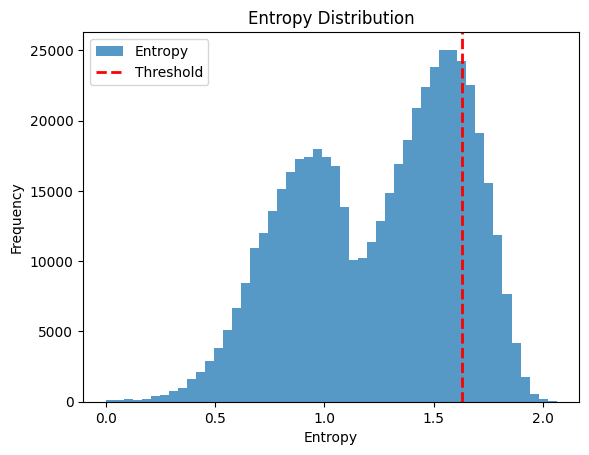

分界值: 1.627087050366117


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 提取熵值
entropy = result_df['Entropy']

# 计算熵的均值和标准差
entropy_mean = entropy.mean()
entropy_std = entropy.std()
entropy_threshold = entropy_mean + entropy_std

# 绘制熵的分布图
plt.hist(entropy, bins=50, alpha=0.75, label='Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.axvline(entropy_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[entropy <= entropy_threshold]

# 输出结果
print(f"分界值: {entropy_threshold}")


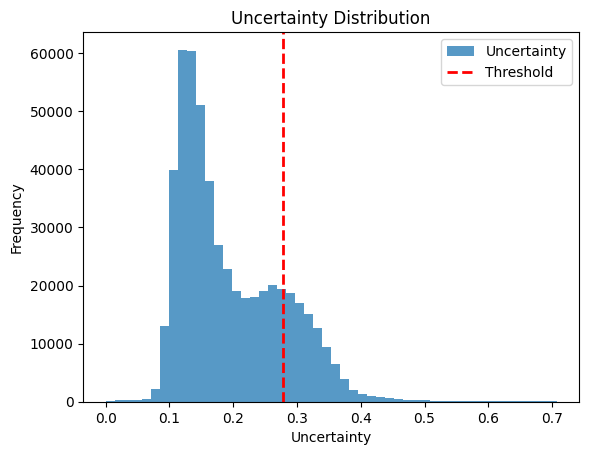

不确定性分界值: 0.27809831783658645


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
uncertainty = result_df['Uncertainty']
# 计算不确定性的均值和标准差
uncertainty_mean = uncertainty.mean()
uncertainty_std = uncertainty.std()
uncertainty_threshold = uncertainty_mean + uncertainty_std

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[uncertainty <= uncertainty_threshold]

# 输出结果
print(f"不确定性分界值: {uncertainty_threshold}")


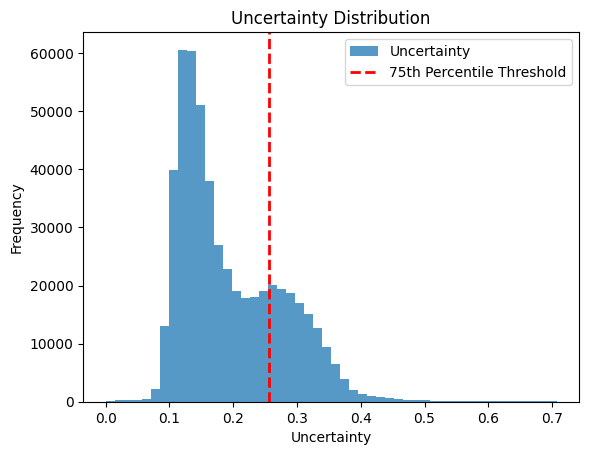

第75百分位数分界值: 0.2553864121437073


In [106]:
# 计算第75百分位数
uncertainty_threshold_75 = np.percentile(uncertainty, 75)

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold_75, color='r', linestyle='dashed', linewidth=2, label='75th Percentile Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions_75 = result_df[uncertainty <= uncertainty_threshold_75]

# 输出结果
print(f"第75百分位数分界值: {uncertainty_threshold_75}")

In [10]:
# 读取字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict\soil_type_dict.json', 'r', encoding='utf-8') as json_file:
    search_dict = json.load(json_file)

In [6]:
def add_soil_type_to_dict(soil_dict, soil_type, soil_class, soil_subclass, soil_genus):
    """
    向土壤类型字典中添加新的土种及其分类信息
    
    参数:
    soil_dict (dict): 现有的土壤类型字典
    soil_type (str): 土种名称
    soil_class (str): 土类
    soil_subclass (str): 亚类
    soil_genus (str): 土属
    
    返回:
    dict: 更新后的字典
    """
    # 创建土壤信息字典
    soil_info = {
        "土类": soil_class,
        "亚类": soil_subclass,
        "土属": soil_genus
    }
    
    # 检查是否包含括号
    if '(' in soil_type and ')' in soil_type:
        # 找到括号的位置
        start_idx = soil_type.index('(')
        end_idx = soil_type.index(')')
        
        # 提取括号内的内容（不包含括号）
        bracket_content = soil_type[start_idx + 1:end_idx]
        
        # 生成三种形式
        original_type = soil_type  # 原始形式
        direct_type = soil_type[:start_idx] + bracket_content + soil_type[end_idx + 1:]  # 括号内容直接形式
        without_bracket_type = soil_type[:start_idx] + soil_type[end_idx + 1:]  # 无括号内容形式
        
        # 添加到字典
        soil_dict[original_type] = soil_info
        soil_dict[direct_type] = soil_info
        soil_dict[without_bracket_type] = soil_info
    else:
        # 如果没有括号，直接添加原始形式
        soil_dict[soil_type] = soil_info
    
    return soil_dict

In [7]:

# 使用示例
# 创建新的土壤类型
search_dict = add_soil_type_to_dict(
    search_dict,
    "厚层红泥质黄壤",
    "黄壤",
    "典型黄壤",
    "红泥质黄壤"
)
# 保存字典到json文件
with open(r'D:\worker_code\Terrain_Test\data\soil_dict\soil_type_dict.json', 'w',encoding='utf-8') as json_file:
    json.dump(search_dict, json_file)

In [102]:
search_file_path = r"D:\worker\工作\work\三普\数据\色标\分类表_填充.xlsx"

In [117]:
sh_df = pd.read_excel(search_file_path)
# 去掉sh_df中各个列中的特殊符号，包括空格、换行、制表符等

def clean_dataframe(df):
    # 创建DataFrame的副本以避免修改原始数据
    cleaned_df = df.copy()
    
    # 定义清理单个字符串的函数
    def clean_string(value):
        if isinstance(value, str):
            # 替换换行符、制表符为空格
            value = value.replace('\n', '').replace('\t', '')
            # 去除首尾空格
            value = value.strip()
            # 将多个空格替换为单个空格
            value = ' '.join(value.split())
            return value
        return value
    # 对DataFrame中的每个元素应用清理函数
    cleaned_df = cleaned_df.map(clean_string)
    
    return cleaned_df
# 使用示例：
sh_df = clean_dataframe(sh_df)
sh_df = clean_dataframe(sh_df)


In [123]:
# 创建一个字典，土种为键，内嵌字典{土类，亚类，土属}为值
sh_dict = {}
for index, row in sh_df.iterrows():
    def process_soil_type(row):
        """
        处理土种名称，生成多个变体作为字典键
        
        对于包含括号的土种名称如'薄层(砾)黏质红色石灰土'，生成三种形式：
        1. 原始形式：薄层(砾)黏质红色石灰土
        2. 括号内容直接形式：薄层砾黏质红色石灰土
        3. 无括号内容形式：薄层黏质红色石灰土
        """
        soil_type = row['土种']
        soil_info = {"土类": row['土类'], "亚类": row['亚类'], "土属": row['土属']}
        
        if '(' in soil_type and ')' in soil_type:
            # 找到括号的位置
            start_idx = soil_type.index('(')
            end_idx = soil_type.index(')')
            # 提取括号内的内容（不包含括号）
            bracket_content = soil_type[start_idx + 1:end_idx]
            # 生成三种形式
            original_type = soil_type  # 原始形式
            direct_type = soil_type[:start_idx] + bracket_content + soil_type[end_idx + 1:]  # 括号内容直接形式
            without_bracket_type = soil_type[:start_idx] + soil_type[end_idx + 1:]  # 无括号内容形式
            # 添加到字典
            sh_dict[original_type] = soil_info
            sh_dict[direct_type] = soil_info
            sh_dict[without_bracket_type] = soil_info
        else:
            # 如果没有括号，直接添加原始形式
            sh_dict[soil_type] = soil_info
    process_soil_type(row)

sh_dict
# 保存字典到json文件
with open(r'D:\worker_code\Terrain_Test\data\soil_dict\soil_type_dict.json', 'w',encoding='utf-8') as json_file:
    json.dump(sh_dict, json_file)
# 保存字典到json文件 中文可读
with open(r'D:\worker_code\Terrain_Test\data\soil_dict\soil_type_dict_readable.json', 'w', encoding='utf-8') as json_file:
    json.dump(sh_dict, json_file, ensure_ascii=False, indent=4)
